##**Sistem Rekomendasi: Rekomendasi Film untuk Pengguna**

**Oleh** : Alifia Feiling A.S

*Proyek Submission 2 - Machine Learning Terapan Dicoding*

#Pendahuluan

Pada proyek ini akan dibuat sistem rekomendasi untuk memberikan suatu saran rekomendasi kepada pengguna secara efektif dengan Collaborative Filtering.

#**1. Mempersiapkan Dataset**


**1.1. Kredensial akun kaggle**

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!ls ~/.kaggle

kaggle.json


**1.2. Mengunduh dan Mempersiapkan Dataset**

In [7]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download -d rounakbanik/the-movies-dataset

 99% 226M/228M [00:05<00:00, 28.9MB/s]
100% 228M/228M [00:06<00:00, 39.6MB/s]


In [8]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!mkdir film
!unzip -qq /content/the-movies-dataset.zip -d film
!ls film

credits.csv   links.csv        movies_metadata.csv  ratings_small.csv
keywords.csv  links_small.csv  ratings.csv


#**2. Mengimpor pustaka/modul Python**

In [9]:
#untuk pengolahan data
import numpy as np
import pandas as pd

#untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

#pengumpul data
from collections import defaultdict

#untuk pembuatan sistem rekomendasi
!pip install scikit-surprise
import surprise
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset
from surprise import KNNBasic

#untuk evaluasi sistem rekomendasi
from surprise import accuracy

     |████████████████████████████████| 11.8 MB 31 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619436 sha256=18b57af65ef7a72ca0248592bbd16d187e0691223e55adb35bdc1fd85caa21b8
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


# **3. Pemahaman Data (Data Understanding)**

## **3.1 Memuat data pada sebuah dataframe menggunakan pandas**

###**3.1.1 Dataset Rating**

In [10]:
peringkat = pd.read_csv("/content/film/ratings_small.csv")

In [11]:
#pratinjau dataset
peringkat

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


### **3.1.2 Dataset Judul**

In [12]:
judul = pd.read_csv("/content/film/movies_metadata.csv")
#pratinjau dataset
judul

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,Fa

In [13]:
judul = judul[['title']]
judul

,title
0,Toy Story
1,Jumanji
2,Grumpier Old Men
3,Waiting to Exhale
4,Father of the Bride Part II
...,...
45461,Subdue
45462,Century of Birthing
45463,Betrayal
45464,Satan Triumphant


###**3.1.3 Menggabungkan dataset rating dan judul**

In [14]:
datafilm = pd.concat([peringkat, judul], axis=1)
datafilm

,userId,movieId,rating,timestamp,title
0,1,31,2.5,1260759144,Toy Story
1,1,1029,3.0,1260759179,Jumanji
2,1,1061,3.0,1260759182,Grumpier Old Men
3,1,1129,2.0,1260759185,Waiting to Exhale
4,1,1172,4.0,1260759205,Father of the Bride Part II
...,...,...,...,...,...
99999,671,6268,2.5,1065579370,NaN
100000,671,6269,4.0,1065149201,NaN
100001,671,6365,4.0,1070940363,NaN
100002,671,6385,2.5,1070979663,NaN


#**3.2 Keterangan kolom pada dataset**

In [15]:
#memuat informasi dataframe
datafilm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
 4   title      45460 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ MB


In [16]:
#menghitung jumlah data kosong pada setiap kolom
datafilm.isna().sum

<bound method DataFrame.sum of         userId  movieId  rating  timestamp  title
0        False    False   False      False  False
1        False    False   False      False  False
2        False    False   False      False  False
3        False    False   False      False  False
4        False    False   False      False  False
...        ...      ...     ...        ...    ...
99999    False    False   False      False   True
100000   False    False   False      False   True
100001   False    False   False      False   True
100002   False    False   False      False   True
100003   False    False   False      False   True

[100004 rows x 5 columns]>

In [17]:
#memuat deskripsi setiap kolom dataframe
datafilm.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


##**3.3 Visualisasi Data**

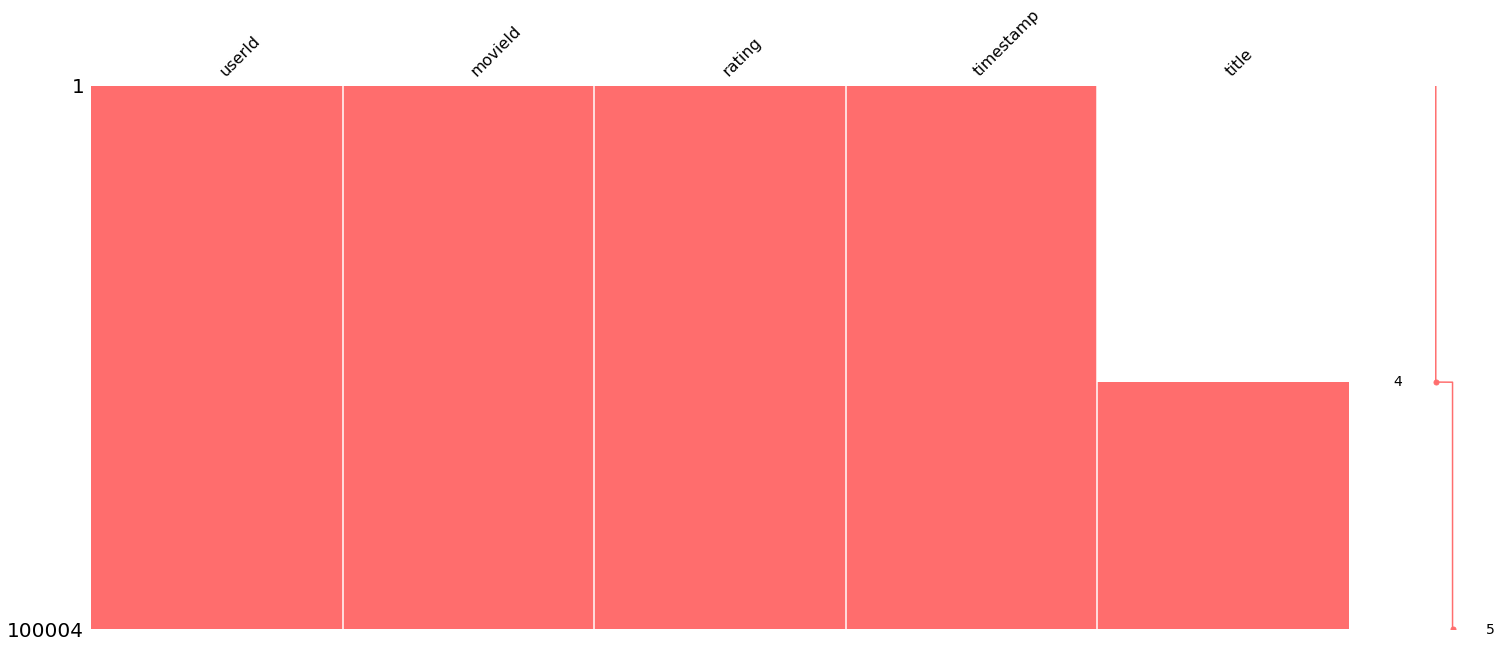

In [18]:
# visualisasi data kosong pada setiap kolom
sorted_null = msno.nullity_sort(datafilm, sort='ascending') 
figures = msno.matrix(sorted_null, color=(1, 0.43, 0.43))

Text(0.5, 1.0, 'Korelasi antar kolom')

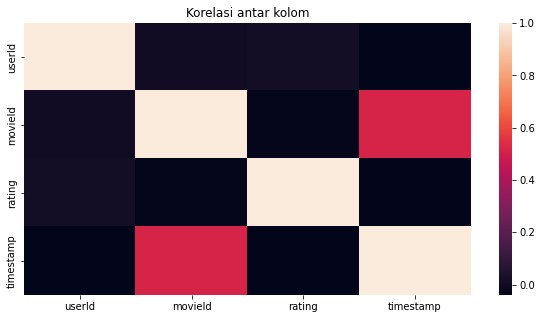

In [19]:
#visualisasi korelasi antar kolom
plt.figure(figsize=(10,5))
sns.heatmap(datafilm.corr());
plt.title("Korelasi antar kolom")

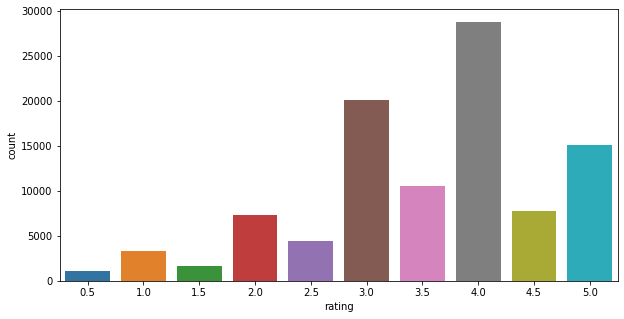

In [20]:
#visualisasi data berdasarkan jumlah rating
ims = (10, 8)
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x="rating", data=peringkat)

# **4. Persiapan Data (Data Preparation)**

##**4.1 Kolom dataset untuk framework surprise**

In [21]:
# Dataset yang akan dipakai untuk train test split dengan framework surprise
reader = Reader()
data = Dataset.load_from_df(datafilm[['userId', 'movieId', 'rating']], reader)


##**4.2 Melakukan pembagian data pada dataset dengan train_test_split**

In [22]:
# Train & Test
trainset, testset = train_test_split(data, test_size=0.20, random_state=50)

# **5. Pembuatan Model**

## **5.1 Pembuatan Model SVD**

In [23]:
# Gunakan fungsi svd() yang sudah disediakan pada surprise
algo_svd = SVD()
prediction_mf = algo_svd.fit(trainset).test(testset)

# Prediksi
prediction_mf

[Prediction(uid=130, iid=1148, r_ui=4.0, est=3.7565420470387645, details={'was_impossible': False}),
 Prediction(uid=468, iid=7153, r_ui=3.5, est=3.384948740915029, details={'was_impossible': False}),
 Prediction(uid=457, iid=58559, r_ui=0.5, est=3.0769884730639205, details={'was_impossible': False}),
 Prediction(uid=564, iid=3324, r_ui=1.0, est=2.9468364356784225, details={'was_impossible': False}),
 Prediction(uid=77, iid=3753, r_ui=3.5, est=3.0476711398977607, details={'was_impossible': False}),
 Prediction(uid=564, iid=1970, r_ui=3.0, est=3.3940221820659016, details={'was_impossible': False}),
 Prediction(uid=524, iid=481, r_ui=3.0, est=3.5314200274353253, details={'was_impossible': False}),
 Prediction(uid=105, iid=2247, r_ui=3.0, est=3.249767137559783, details={'was_impossible': False}),
 Prediction(uid=598, iid=1291, r_ui=4.0, est=4.158565674375007, details={'was_impossible': False}),
 Prediction(uid=46, iid=91529, r_ui=5.0, est=4.938470393485062, details={'was_impossible': Fals

In [24]:
algo_SVD = SVD(n_factors = 11)
algo_SVD.fit(trainset)


#  Prediksi peringkat untuk semua pasangan (i,j) yang TIDAK dalam set pelatihan.
testset = trainset.build_anti_testset()

predictions = algo_SVD.test(testset)

# bagian dari daftar predikisi
predictions[0:2]

[Prediction(uid=253, iid=515, r_ui=3.5418984288089197, est=4.136784004181578, details={'was_impossible': False}),
 Prediction(uid=253, iid=3481, r_ui=3.5418984288089197, est=3.994759456542615, details={'was_impossible': False})]

In [25]:
def get_top_n(predictions, userId, datafilm, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    #dokumentasi surprise
    
    #1. map prediksi setiap pengguna
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Kemudian urutkan prediksi untuk setiap pengguna dan ambil k yang tertinggi
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
  
    
    #3. Memberi tahu berapa banyak film yang telah dinilai pengguna
    user_data = datafilm[datafilm.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame dengan prediksi
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #5. Return pred_usr 
    pred_usr = preds_df[preds_df["userId"] == (userId)]
            
    #6. Return hist_usr
    hist_usr = datafilm[datafilm.userId == (userId) ].sort_values("rating", ascending = False)
    
    
    return hist_usr, pred_usr

## **5.2 Rekomendasi SVD**

In [26]:
#pemanggilan data pengguna dengan userId 12
hist_SVD_124, pred_SVD_124 = get_top_n(predictions, datafilm = datafilm, userId = 12)


User 12 has already rated 61 movies.


In [27]:
#top-15 rekomendasi pengguna dengan userId 12
hist_SVD_124.head(15)

,userId,movieId,rating,timestamp,title
885,12,3879,5.0,968044949,Casablanca
881,12,3865,5.0,968045015,North by Northwest
879,12,3863,5.0,968045015,Gaslight
872,12,3825,5.0,968045142,Singin' in the Rain
866,12,3793,5.0,968045232,Mother Night
839,12,1215,5.0,968045353,Small Faces
840,12,1220,5.0,955407153,Bound
842,12,1235,5.0,968045354,Death in Brunswick
858,12,3298,4.0,968045529,Bogus
845,12,1387,4.0,968045475,Lover's Knot


##**5.2 Pembuatan Model KNN**

In [28]:
#pembuatan model knn
sim_options = {'name': 'pearson_baseline','shrinkage': 0}
algo = KNNBasic(sim_options=sim_options)
algo_knn = KNNBasic(k=75, sim_options=sim_options)
prediction_knn = algo_knn.fit(trainset).test(testset)

# Prediksi
prediction_knn

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


[Prediction(uid=253, iid=515, r_ui=3.5418984288089197, est=4.226446501590628, details={'actual_k': 17, 'was_impossible': False}),
 Prediction(uid=253, iid=3481, r_ui=3.5418984288089197, est=3.739495236713191, details={'actual_k': 32, 'was_impossible': False}),
 Prediction(uid=253, iid=2194, r_ui=3.5418984288089197, est=4.081628654065118, details={'actual_k': 34, 'was_impossible': False}),
 Prediction(uid=253, iid=58559, r_ui=3.5418984288089197, est=4.530133022019336, details={'actual_k': 42, 'was_impossible': False}),
 Prediction(uid=253, iid=750, r_ui=3.5418984288089197, est=4.463195083519733, details={'actual_k': 31, 'was_impossible': False}),
 Prediction(uid=253, iid=2951, r_ui=3.5418984288089197, est=4.580799688842358, details={'actual_k': 6, 'was_impossible': False}),
 Prediction(uid=253, iid=7153, r_ui=3.5418984288089197, est=4.414375925694147, details={'actual_k': 59, 'was_impossible': False}),
 Prediction(uid=253, iid=6240, r_ui=3.5418984288089197, est=3.0, details={'actual_k':

# **6. Pengujian Model**

##**6.1 Pengujian Rekomendasi Model Algo SVD**

In [29]:
#pengujian rekomendasi model algo SVD
recom_svd = algo_svd.predict(uid=1,iid=5)
recom_svd

Prediction(uid=1, iid=5, r_ui=None, est=2.6420444033909565, details={'was_impossible': False})

## **6.2 Pengujian Rekomendasi Model KNN**

In [30]:
# pegujian rekomendasi model KNN
recom_knn = algo_knn.predict(uid=30,iid=5655)
recom_knn

Prediction(uid=30, iid=5655, r_ui=None, est=3.5418984288089197, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

# **6. Evaluasi**

## **6.1 Evaluasi Model Algo SVD**

In [31]:
accuracy.mae(prediction_mf)
accuracy.fcp(prediction_mf)
accuracy.rmse(prediction_mf)

MAE:  0.6843
FCP:  0.6423
RMSE: 0.8864


0.8864105844214443

## **6.2 Evaluasi Model KNN**

In [34]:
accuracy.mae(prediction_knn)
#accuracy.fcp(prediction_knn)
accuracy.rmse(prediction_knn)

MAE:  0.5190
RMSE: 0.8013


0.8013084010920066

#**Penutupan** 

Disimpulkan bahwa penggunaan metode collaborative filtering dapat memberikan suatu saran rekomendasi kepada pengguna secara efektif, baik menggunakan algoritma KNN maupun menggunakan SVD dengan metode matrix factorization. 

### **Referensi**

1. https://scikit-learn.org/stable/modules/classes.html
2. https://plotly.com/python/
3. https://www.kaggle.com/faridrizqis/recommendersystem-colaborativefilter-surprise#Menggunakan-Metode-SVD
4. https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system#Content-Based-Filtering